In [1]:
# Standard Python modules
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.patheffects as pe

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap
from constants import ucsd_colors

ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths
server = "skyriver"
if server == "comet":
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
elif server == "skyriver":
    path_to_data = '/work/dnash/data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


In [3]:
ext1 = [-141., -130., 54.5, 60.] # extent of SEAK 
ext2 = [-175., -120., 50., 75.] # extend of AK
exts = [ext1, ext2]



### Read preprocessed USGS GMTED2010 7.5 arc second elevation data

In [4]:
## Open GMTED2010 7.5 arc second elevation data
elev = xr.open_dataset(path_to_data + 'preprocessed/seak_gmted_mea075.nc')

### Read Glacier and Stream Shapefile

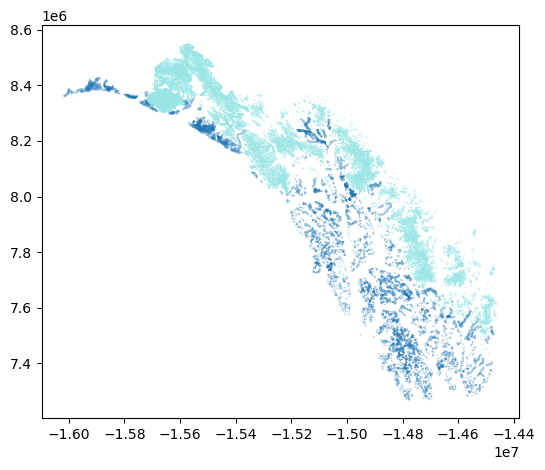

In [5]:
fp = path_to_data + 'downloads/Alaska_Glacier_Inventory_RGI/Alaska_Glacier_Inventory_RGI.shp'
polys = gpd.read_file(fp, bbox=[ext1[0], ext1[3], ext1[1], ext1[2]]) # read shapefile
crs_polys = ccrs.epsg('3395')
polys = polys.to_crs("EPSG:3395") # reproject to Mercator

fp = path_to_data + '/downloads/SEA/sea_stream.shp'
river = gpd.read_file(fp) # read shapefile
river = river.to_crs("EPSG:3395") # reproject to Mercator
crs_polys = ccrs.epsg('3395')
## test
fig, ax = plt.subplots()
river.plot(ax=ax, facecolor='None', alpha=0.4);
polys.plot(ax=ax, facecolor='c', alpha=0.4);
plt.tight_layout();

## Station and City Data

In [6]:
## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'left'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

## Make Figure

In [7]:
lbl_dict = {'Lynn Canal': (-135.113223, 58.700391),
            'Dixon Entrance': (-131.595389, 54.737840),
            'Gulf of Alaska': (-138., 57.5),
            'Glacier Bay National Park and Preserve': (-137.102628, 58.43),
            'Biorka Island': (-135.5393, 56.8545)
    }

riv_dict = {'Chilkat River': (-135.820573, 59.348265),
            'Tsirku River': (-135.907303, 59.379440),
            'Skagway River': (-135.270988, 59.485373),
            'Taiya River': (-135.352027, 59.506408),
            'Dyea': (-135.359958, 59.502532),
            'Chilkoot Inlet': (-135.356073, 59.224357),
            'Chilkat Inlet': (-135.463876, 59.190260),
    }

riv_dict = {'Chilkat River': (-135.820573, 59.348265),
            'Tsirku River': (-136., 59.33),
            'Skagway River': (-135.25, 59.45),
            'Taiya River': (-135.352027, 59.55),
            'Dyea': (-135.359958, 59.502532),
            'Chilkoot Inlet': (-135.35, 59.224357),
            'Chilkat Inlet': (-135.5, 59.190260),
            'Taiya Inlet': (-135.369184, 59.373462)
    }

xytext = [(0,-14), (0, 10)]

In [8]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.Mercator() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-141., -130., 54.5, 60.] # extent of SEAK 
ext3 = [-136.15, -135.1, 59.15, 59.6] # extent of Klukwan and Skagway
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)

# make a colormap that has land and ocean clearly delineated and of the
# same length (256 + 256)
colors_undersea = plt.cm.terrain(np.linspace(0, 0.17, 256))
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
all_colors = np.vstack((colors_undersea, colors_land))
terrain_map = mcolors.LinearSegmentedColormap.from_list(
    'terrain_map', all_colors)
# make the norm:  Note the center is offset so that the land has more
# dynamic range:
divnorm = mcolors.TwoSlopeNorm(vmin=-0.25, vcenter=1, vmax=3000)

lons = elev.lon
lats = elev.lat

wc_rgb = (86./255., 105./255., 166./255.) # color for water features
wc_cmyk = (48., 37., 0., 35.)


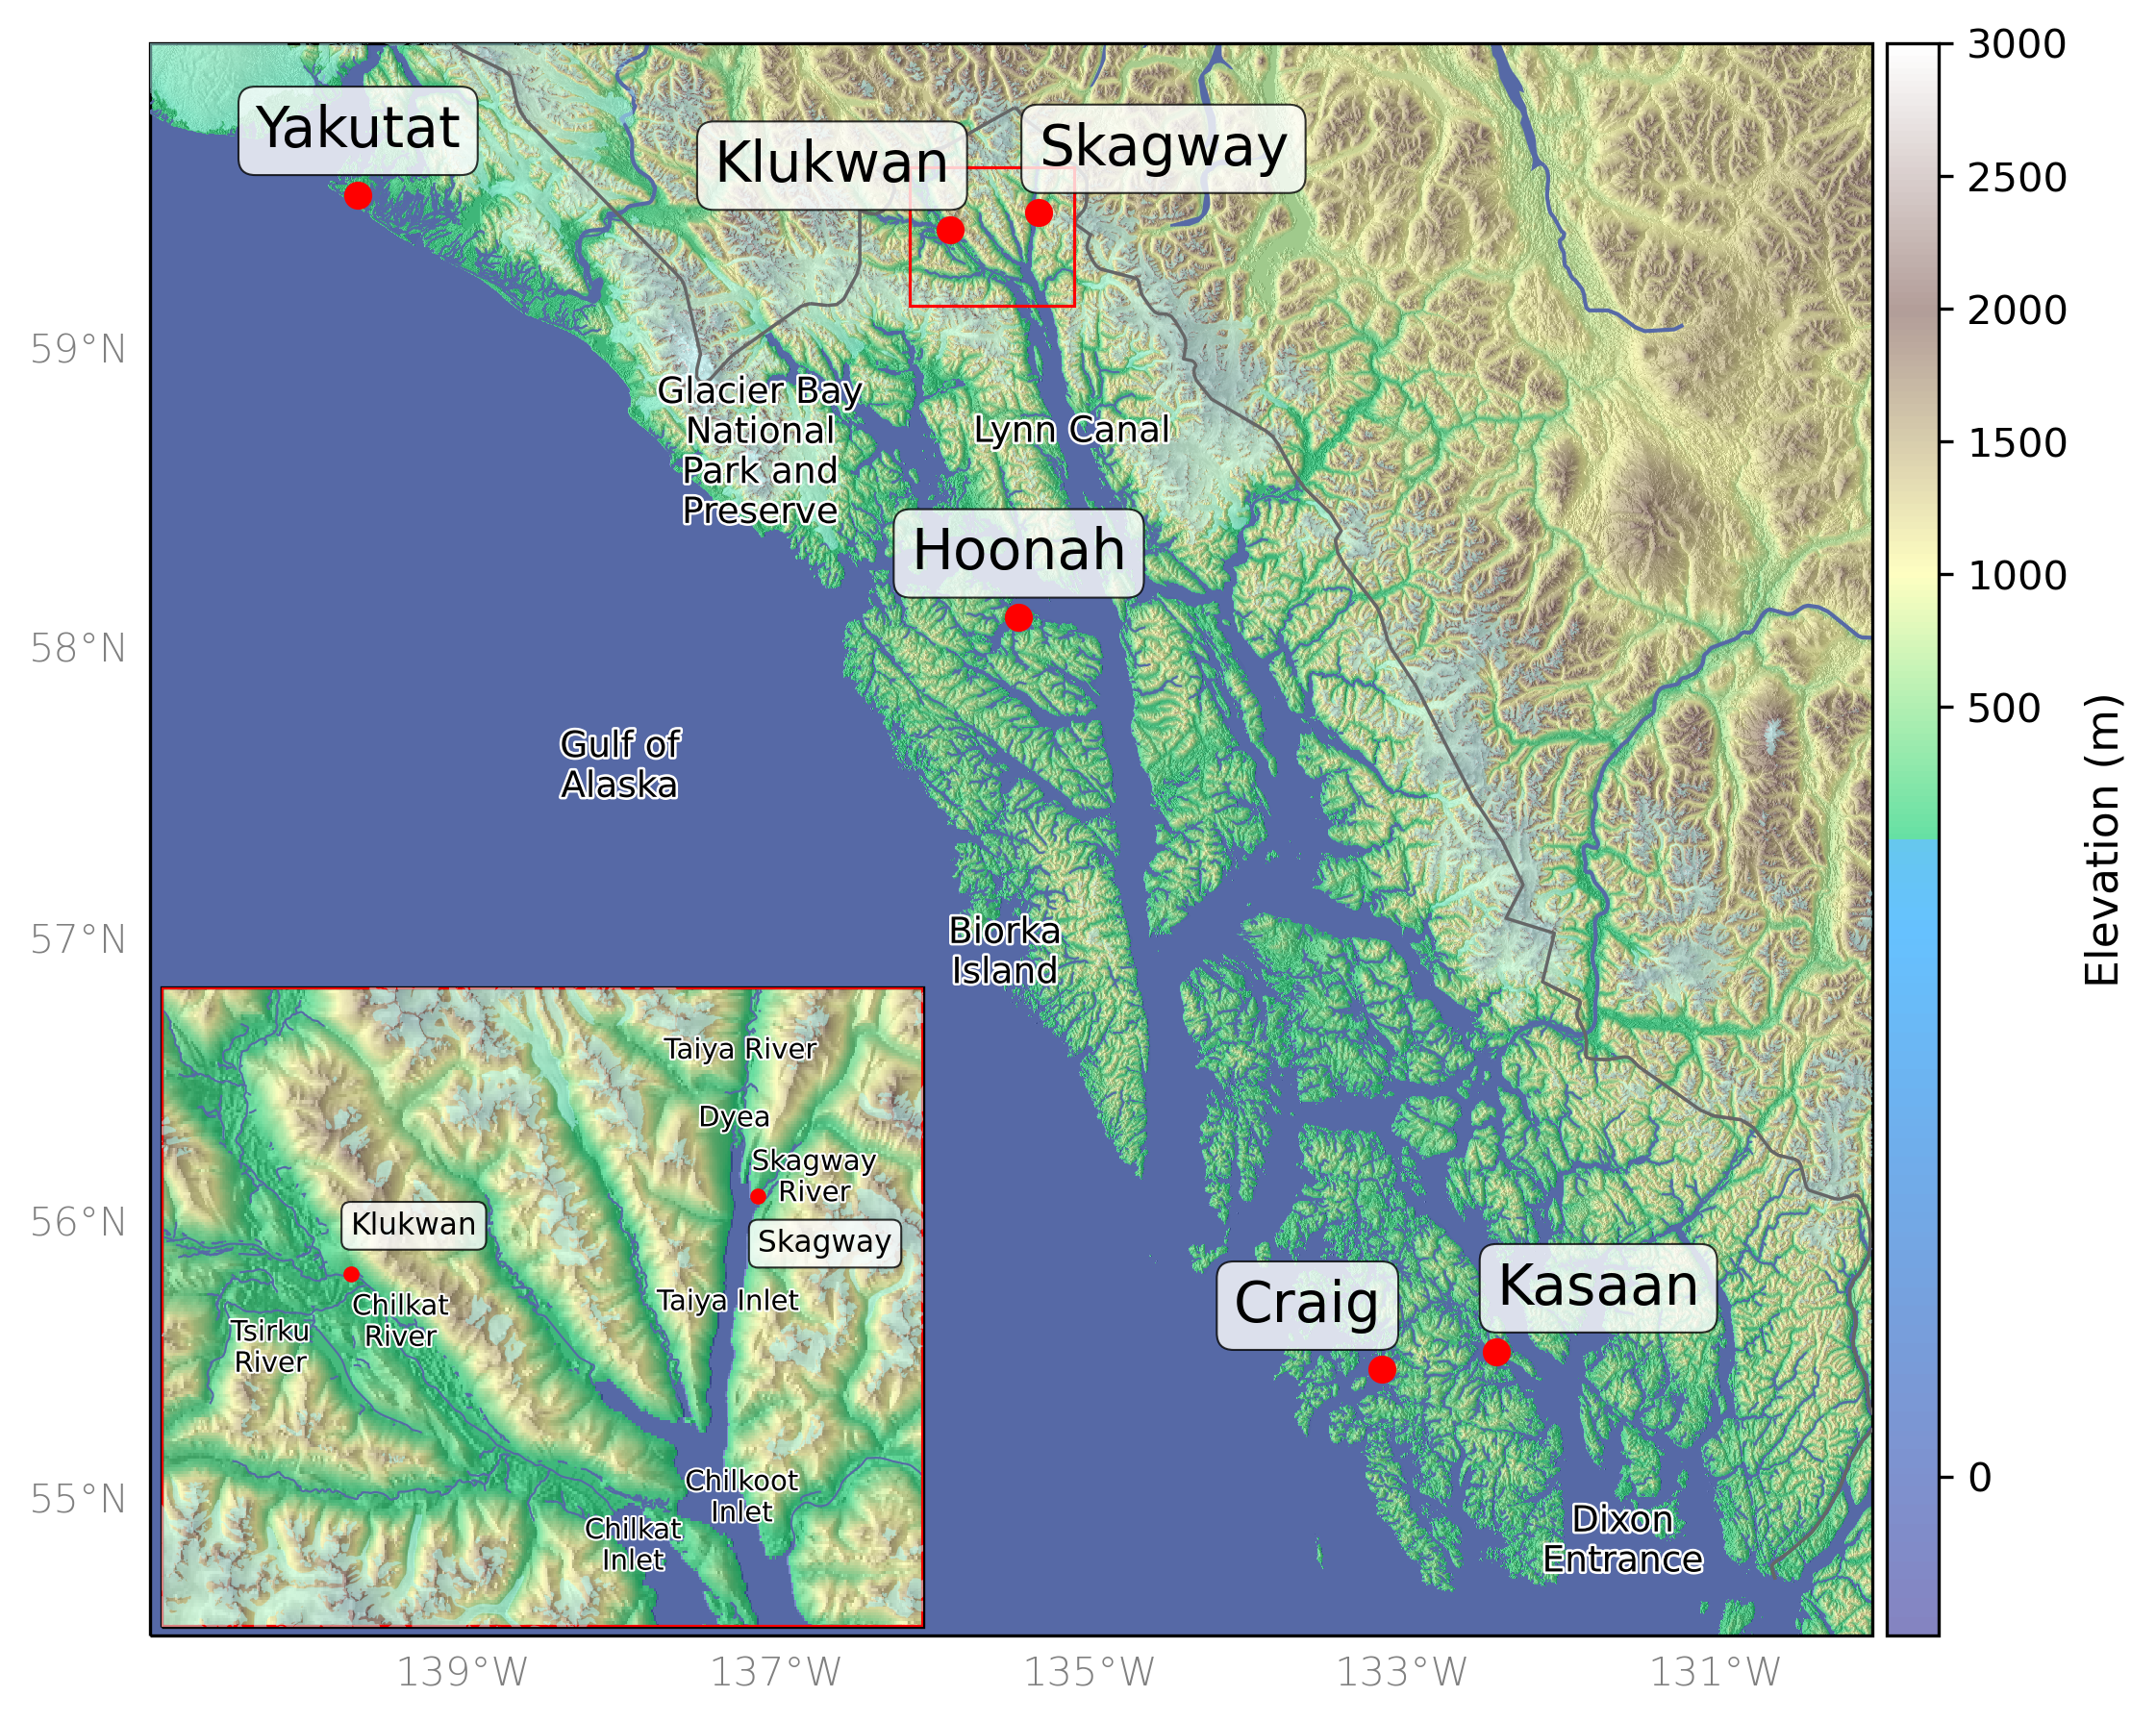

In [9]:
# Create figure
fig = plt.figure(figsize=(8, 12))
fig.dpi = 300
fname = path_to_figs + 'elevation_7.5arcsec_with_inset'
fmt = 'png'

nrows = 1
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')


for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, mask_ocean=False, coastline=False)

    # topo with bright cmap
    cs = ax.pcolormesh(lons, lats, elev.hillshade,
                        cmap=cmo.gray, transform=datacrs, alpha=0.7)
    
    cf = ax.pcolormesh(lons, lats, elev.elev, rasterized=True, norm=divnorm,
                        cmap=terrain_map, shading='auto', transform=datacrs, alpha=0.6)
    
    
    # add glaciers
    ax.add_geometries(polys['geometry'], crs=crs_polys,
                      facecolor=(0.7, 1, 1, 0.7), ec='None',
                      zorder=100, alpha=0.5)
    
    # add rivers/streams
    ax.add_geometries(river['geometry'], crs=crs_polys,
                      facecolor='None', ec=wc_rgb, linewidth=0.5,
                      zorder=99)

    ax.add_feature(cfeature.LAKES, facecolor=wc_rgb)
    ax.add_feature(cfeature.RIVERS, edgecolor=wc_rgb)
    ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8, zorder=199)
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    
    ## Plot the locations of the focus communities
    # zip joins x and y coordinates in pairs
    for x,y,z,ha in zip(xs,ys, lbl1, lbl_align):

        # Plot Location of pts
        ax.plot(x, y, 'ro', markersize=6, transform=datacrs, zorder=201)

        ax.annotate(z, # this is the text
                   (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,12), # distance from text to points (x,y)
                    ha=ha, # horizontal alignment can be left, right or center
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                    xycoords=transform,
                    zorder=200,
                    fontsize=14)
    
    ## add additional labels
    style = {'size': 9, 'color': 'black', 'fontweight': 'normal'}
    for lbl in lbl_dict:
        xy = lbl_dict[lbl]
        ax.annotate(textwrap.fill(lbl, 11), # this is the text
                    xy, # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,0), # distance from text to points (x,y)
                    ha='center', # horizontal alignment can be left, right or center
                    xycoords=transform,
                    zorder=200,
                    path_effects=[pe.withStroke(linewidth=1.25, foreground="white")],
                    **style)
        
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                    fill=False,
                                    edgecolor='r',
                                    linewidth=0.75,
                                    transform=datacrs,
                                    zorder=199))

    ### Add Klukwan/Skagway Inset
    ### Add inset map  [left, bottom, width, height]
    axins = plt.axes([0.13, 0.195, 0.33, 0.33], projection=mapcrs)
    axins.set_extent(ext3, crs=datacrs)
    
    axins.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                    fill=False,
                                    edgecolor='r',
                                    linewidth=1.0,
                                    transform=datacrs,
                                    zorder=100))
    
    # topo with bright cmap
    cs = axins.pcolormesh(lons, lats, elev.hillshade,
                        cmap=cmo.gray, transform=datacrs, alpha=0.7)
    
    cf = axins.pcolormesh(lons, lats, elev.elev, rasterized=True, norm=divnorm,
                        cmap=terrain_map, shading='auto', transform=datacrs, alpha=0.6)
    
    
    # add glaciers
    axins.add_geometries(polys['geometry'], crs=crs_polys,
                      facecolor=(0.7, 1, 1, 0.7), ec='None',
                      zorder=100, alpha=0.5)
    
    # add rivers/streams
    axins.add_geometries(river['geometry'], crs=crs_polys,
                      facecolor='None', ec=wc_rgb, linewidth=0.5,
                      zorder=99)
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(axins)
    
    ## Plot the locations of the focus communities
    # zip joins x and y coordinates in pairs
    for x,y,z,ha,xy in zip(xs[1:3],ys[1:3], lbl1[1:3], lbl_align[1:3], xytext):

        # Plot Location of pts
        axins.plot(x, y, 'ro', markersize=3, transform=datacrs, zorder=201)

        axins.annotate(z, # this is the text
                   (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=xy, # distance from text to points (x,y)
                    ha='left', # horizontal alignment can be left, right or center
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="k", lw=0.5, alpha=0.8),
                    xycoords=transform,
                    zorder=200,
                    fontsize=7.5)
    
    ## add additional labels
    style = {'size': 7, 'color': 'black', 'fontweight': 'normal'}
    for lbl in riv_dict:
        xy = riv_dict[lbl]
        axins.annotate(textwrap.fill(lbl, 11), # this is the text
                    xy, # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,0), # distance from text to points (x,y)
                    ha='center', # horizontal alignment can be left, right or center
                    xycoords=transform,
                    zorder=200,
                    path_effects=[pe.withStroke(linewidth=1, foreground="white")],
                    **style)



# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('Elevation (m)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()